# Introduction to Federal Reserve Economic Research ([FRED](https://research.stlouisfed.org/))

The [Federal Reserve](https://www.federalreserve.gov/aboutthefed.htm) is a massive organization dedicated to "support effective operation of the U.S. economy". It is the central bank of the US. Among other things, this means that it has a strong focus on policy research and economic governance. In addition to having a massive [balance sheet](https://www.federalreserve.gov/monetarypolicy/quarterly-balance-sheet-developments-report.htm), the "Fed" has a huge research staff dedicated to the collection and analysis of economic data.  

While the [Board of Governors](https://www.federalreserve.gov/aboutthefed/bios/board/default.htm) sits here in DC, the Fed is also comprised of 12 regional banks and the [Federal Open Market Committee](https://www.federalreserve.gov/monetarypolicy/fomc.htm).

<a href="https://www.federalreserve.gov/aboutthefed/structure-federal-reserve-system.htm">
    <img src="https://www.federalreserve.gov/aboutthefed/images/figure_1.1.jpg" width=700>
</a>

The regional banks do not all perform the same functions.  Each has their areas of expertise, in addition to broad responsibilities for regional analysis.

<a href="https://en.wikipedia.org/wiki/Federal_Reserve_Bank">
    <img src="https://upload.wikimedia.org/wikipedia/commons/8/8a/Federal_Reserve_Districts_Map_-_Banks_%26_Branches.png" width=700>
</a>

The [St. Louis branch](https://www.federalreserve.gov/aboutthefed/federal-reserve-system-st-louis.htm) of the Fed has emerged as a dominant provider of economic data for the general public. This isn't because other banks do not provide data ([they do](https://www.newyorkfed.org/data-and-statistics)), but the [FRED API](https://research.stlouisfed.org/docs/api/), in particular, is very accessible and wide in scope. Moreover, they have taken on an aggregator role that makes data from other sources (e.g. Census) easier to access with a consistent API. This notebook will introduce a component of this API so that you can also access this incredible, free resource.

In [2]:
# Numerical manipulation
import numpy as np
import pandas as pd
# Data acquisition
import requests
import json
# Visualization
%pylab inline
import matplotlib as mpl
import seaborn as sb
import plotly as pl
# Credential entry
from getpass import getpass

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Define locations for data and figures
data_dir = '../data/'
fig_dir = '../figs/'

Populating the interactive namespace from numpy and matplotlib


## Data Acquisition

### Getting API Keys

For this exercise, we are concerned with understanding the relationship between unemployment rates and health insurance coverage at the state level.  This exercise will require the use of two separate APIs.  One of them is maintained by FRED, and [the other](https://www.census.gov/developers/) is maintained by the [US Census Bureau](https://www.census.gov/en.html). 

Before we can use the FRED API, we need to create a [FRED user account](https://research.stlouisfed.org/useraccount/login/secure/).  Once you sign in, you will encounter an account home screen.

<a href="https://research.stlouisfed.org/useraccount/">
    <img src="../figs/fred_acct.png" width=700>
</a>

If you navigate to "API Keys" you will be taken to a page that both allows you to manage your keys and request a new one. After providing a brief justification, key acquisition should be immediate.

You will also need a key for the Census API. There isn't really a user account, per se, but you do need to [register](https://api.census.gov/data/key_signup.html) your organization and email address.  Upon doing so, they will also provide you with a key.

In [3]:
fred_key = getpass('Enter FRED API Registration Key: ')
census_key = getpass('Enter Census API Registration Key: ')

Enter FRED API Registration Key: ········
Enter Census API Registration Key: ········


### Getting State Unemployment Data From FRED

The FRED system houses **a lot** of data.  Just how much you might ask? Check out the sources below.

In [14]:
def get_fred_info(req='sources?', key=fred_key):
    '''
    Function retrieves information from the Federal Reserve via the FRED API. 
    It relies on the *requests* library, and returns the data sources used by
    FRED as the default. The return format is a dictionary.
    '''
    base = 'https://api.stlouisfed.org/fred/'
    complete_request = base + req + '&api_key={}&file_type=json'.format(fred_key)
#     print(complete_request)
    headers = {
        "Content-type": "application/json"
    }
    result = requests.get(complete_request, headers=headers)
    return json.loads(result.text)

# Capture dictionary of sources (from JSON)
src_d = get_fred_info()

# Capture source names
src_names = [s['name'] for s in src_d['sources']]

print(sorted(src_names))

['Anderson, Richard G.', 'Automatic Data Processing, Inc.', 'Baker, Scott R.', 'Bank for International Settlements', 'Bank of England', 'Bank of Italy', 'Bank of Japan', 'Bank of Mexico', 'Bloom, Nick', 'Board of Governors of the Federal Reserve System (US)', 'Cass Information Systems, Inc.', 'Centers for Disease Control and Prevention', 'Central Bank of the Republic of Turkey', 'Chauvet, Marcelle', 'Chicago Board Options Exchange', 'Council of Economic Advisers (US)', 'CredAbility Nonprofit Credit Counseling & Education', 'DHI Group, Inc.', 'Dartmouth Atlas of Healthcare', 'Davis, Stephen J.', 'Deutsche Bundesbank', 'DiCecio, Riccardo', 'Dow Jones & Company', 'Dwyer, Gerald P.', 'Equifax', 'European Central Bank', 'Eurostat', 'FTSE Russell', 'Federal Bureau of Investigation', 'Federal Deposit Insurance Corporation', 'Federal Financial Institutions Examination Council (US)', 'Federal Reserve Bank of Atlanta', 'Federal Reserve Bank of Chicago', 'Federal Reserve Bank of Cleveland', 'Fede

As can be seen, data is collected from the Federal Reserve and several federal agencies.  The offerings, however, extend far beyond these sources. We will be using the FRED API to capture unemployment information by state.  To see which series we need, we can leverage the keyword tags that FRED provides.  The first thing we need is information on the unemployment rate in each state.  So how about the following tags?

+ `unemployment`
+ `rate`
+ `state`

In [15]:
# Capture relevant series
sur = get_fred_info('tags/series?tag_names=unemployment;state;rate')

# Inspect first few series
print(sur['seriess'][:4])

# sur

[{'id': 'AKINSUREDUR', 'realtime_start': '2018-03-12', 'realtime_end': '2018-03-12', 'title': 'Insured Unemployment Rate in Alaska', 'observation_start': '1986-02-08', 'observation_end': '2018-02-17', 'frequency': 'Weekly, Ending Saturday', 'frequency_short': 'W', 'units': 'Percent', 'units_short': '%', 'seasonal_adjustment': 'Not Seasonally Adjusted', 'seasonal_adjustment_short': 'NSA', 'last_updated': '2018-03-08 08:11:02-06', 'popularity': 1, 'group_popularity': 1}, {'id': 'AKUR', 'realtime_start': '2018-03-12', 'realtime_end': '2018-03-12', 'title': 'Unemployment Rate in Alaska', 'observation_start': '1976-01-01', 'observation_end': '2018-01-01', 'frequency': 'Monthly', 'frequency_short': 'M', 'units': 'Percent', 'units_short': '%', 'seasonal_adjustment': 'Seasonally Adjusted', 'seasonal_adjustment_short': 'SA', 'last_updated': '2018-03-12 15:31:10-05', 'popularity': 35, 'group_popularity': 35}, {'id': 'AKURN', 'realtime_start': '2018-03-12', 'realtime_end': '2018-03-12', 'title': 

Looks like we want sources that have info like `'title':'Unemployment Rate in Alaska'`. The structure of the series id seems pretty straightforward: [state postal code]UR (e.g. AKUR or ALUR). We don't really want to type in all of the states though, so let's use an easy online resource.

In [16]:
# Capture state names and abbreviations from github
states = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')

states.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


Now let's see if we can capture a single series call for the unemployment rate in Alaska.  The nice thing about FRED results is that all of the observations are dumped into the `'observations'` entry of the JSON that is returned. Furthermore, those observations are returned as a list of dictionaries, which several tools know how to easily handle.  What does that mean for us?  We can just wrap that list of dictionaries and return a pandas DataFrame.

In [17]:
# Capture Alaskan unemployment data series
ur_test = get_fred_info('series/observations?series_id=AKUR')

# Capture that series in a pandas DataFrame
ur_test_df = pd.DataFrame(ur_test['observations'])

ur_test_df.head()

,date,realtime_end,realtime_start,value
0,1976-01-01,2018-03-12,2018-03-12,7.1
1,1976-02-01,2018-03-12,2018-03-12,7.100
2,1976-03-01,2018-03-12,2018-03-12,7.0
3,1976-04-01,2018-03-12,2018-03-12,7.000
4,1976-05-01,2018-03-12,2018-03-12,7.000


Now we need to do the same thing, but for all states.  So, we need some way of programmatically building a list of strings that vary only by the state name.  Let's step through how we might do this.  Note that until we are ready to make the call, we are just printing out what each component does.  

In [18]:
# Capture list of state postal abbreviations
print('STATE ABBREVIATIONS: ', [st for st in states['Abbreviation']][:5])

# Capture list of series codes built as the combination of state abbreviations and UR
print('STATE UNEMPLOYMENT RATE SERIES IDS: ',['{}UR'.format(st) for st in states['Abbreviation']][:5])

# Capture the full string we need to feed into `get_fred_info()`
ur_strings = ['series/observations?series_id={}UR'.format(st) for st in states['Abbreviation']]
print('API CALL COMPONENTS FOR STATE UNEMPLOYMENT RATE SERIES: ',ur_strings[:5])

# Capture API components in a dictionary, so they are easily referenced
ur_api_calls = dict(zip(states['Abbreviation'].values, ur_strings))

ur_api_calls

STATE ABBREVIATIONS:  ['AL', 'AK', 'AZ', 'AR', 'CA']
STATE UNEMPLOYMENT RATE SERIES IDS:  ['ALUR', 'AKUR', 'AZUR', 'ARUR', 'CAUR']
API CALL COMPONENTS FOR STATE UNEMPLOYMENT RATE SERIES:  ['series/observations?series_id=ALUR', 'series/observations?series_id=AKUR', 'series/observations?series_id=AZUR', 'series/observations?series_id=ARUR', 'series/observations?series_id=CAUR']


{'AK': 'series/observations?series_id=AKUR',
 'AL': 'series/observations?series_id=ALUR',
 'AR': 'series/observations?series_id=ARUR',
 'AZ': 'series/observations?series_id=AZUR',
 'CA': 'series/observations?series_id=CAUR',
 'CO': 'series/observations?series_id=COUR',
 'CT': 'series/observations?series_id=CTUR',
 'DC': 'series/observations?series_id=DCUR',
 'DE': 'series/observations?series_id=DEUR',
 'FL': 'series/observations?series_id=FLUR',
 'GA': 'series/observations?series_id=GAUR',
 'HI': 'series/observations?series_id=HIUR',
 'IA': 'series/observations?series_id=IAUR',
 'ID': 'series/observations?series_id=IDUR',
 'IL': 'series/observations?series_id=ILUR',
 'IN': 'series/observations?series_id=INUR',
 'KS': 'series/observations?series_id=KSUR',
 'KY': 'series/observations?series_id=KYUR',
 'LA': 'series/observations?series_id=LAUR',
 'MA': 'series/observations?series_id=MAUR',
 'MD': 'series/observations?series_id=MDUR',
 'ME': 'series/observations?series_id=MEUR',
 'MI': 'se

With those API call components ready, we can grab the data series from each state, and throw them all in a single DataFrame.

In [19]:
# Create dictionary to hold data for each state
ur_df_dict = {'date': ur_test_df['date']}

# For each state...
for st in ur_api_calls:
    print(st)
    #... capture the unemployment rate series...
    tmp_json = get_fred_info(ur_api_calls[st])
    #... convert the result to a pandas DataFrame...
    tmp_df = pd.DataFrame(tmp_json['observations'])
    #... update ur_df_dict with the data series
    ur_df_dict.update({st: tmp_df['value'].values})
    
# Convert dictionary to DF
ur_df = pd.DataFrame(ur_df_dict)

# Convert the date to a period object
ur_df['date'] = ur_df['date'].apply(lambda x: pd.Period(x, freq='M'))

# Set the date variable to the index
ur_df.set_index('date', inplace=True)

# Convert values to float
ur_df = ur_df.astype(float)

ur_df.head()

AL
AK
AZ
AR
CA
CO
CT
DE
DC
FL
GA
HI
ID
IL
IN
IA
KS
KY
LA
ME
MT
NE
NV
NH
NJ
NM
NY
NC
ND
OH
OK
OR
MD
MA
MI
MN
MS
MO
PA
RI
SC
SD
TN
TX
UT
VT
VA
WA
WV
WI
WY


,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
date,,,,,,,,,,,,,,,,,,,,,
1976-01,7.1,6.7,7.4,10.3,9.1,5.5,9.8,9.0,7.7,9.6,...,3.2,6.0,5.8,5.8,5.9,8.7,8.7,5.8,7.8,4.1
1976-02,7.1,6.7,7.4,10.3,9.1,5.5,9.8,9.0,7.7,9.6,...,3.2,6.0,5.9,5.8,5.9,8.7,8.7,5.8,7.9,4.1
1976-03,7.0,6.6,7.4,10.2,9.0,5.4,9.8,9.0,7.7,9.5,...,3.1,6.0,5.9,5.8,5.9,8.7,8.7,5.7,7.9,4.2
1976-04,7.0,6.5,7.3,10.0,9.0,5.4,9.7,8.8,8.0,9.3,...,3.1,5.9,5.9,5.7,5.8,8.7,8.7,5.6,7.9,4.1
1976-05,7.0,6.4,7.2,9.8,8.9,5.5,9.6,8.7,8.4,9.1,...,3.0,5.8,5.9,5.6,5.8,8.6,8.7,5.5,7.8,4.1


As will become apparent below, the health insurance information we will retrieve is observed on an annual basis. If we want to examine the association between state unemployment rates and health insurance coverage, we better do something to make sure we have comparable temporal units. That is, we need to use only one unemployment rate value per year. There is more than one way to go about this, but in this case we will use the average across months within a given year.  Fortunately, pandas makes [resampling](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#resampling) super easy.

In [20]:
ur_df_ann = ur_df.resample('A').mean()

ur_df_ann

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
date,,,,,,,,,,,,,,,,,,,,,
1976,7.516667,6.766667,6.975000,9.683333,9.108333,5.808333,9.275000,8.950000,8.816667,9.108333,...,3.216667,6.050000,5.783333,5.566667,5.825000,8.325000,8.875000,5.516667,7.325000,3.966667
1977,9.866667,7.316667,6.450000,8.216667,8.333333,6.366667,6.991667,9.183333,8.458333,8.175000,...,3.291667,6.233333,5.325000,5.125000,5.475000,6.983333,8.466667,5.116667,6.883333,3.383333
1978,10.616667,6.316667,6.191667,6.033333,7.158333,5.516667,5.225000,8.275000,7.408333,6.708333,...,3.100000,5.825000,4.775000,3.791667,5.291667,5.600000,6.833333,4.966667,6.175000,3.008333
1979,9.275000,7.175000,6.208333,5.091667,6.241667,4.741667,5.150000,7.025000,7.200000,5.950000,...,3.350000,5.858333,4.358333,4.333333,4.725000,5.141667,6.675000,4.591667,6.916667,2.758333
1980,9.650000,8.883333,7.558333,6.650000,6.850000,5.808333,5.808333,7.366667,7.608333,6.091667,...,4.791667,7.458333,5.141667,6.200000,5.175000,6.183333,8.066667,7.233333,9.466667,3.866667
1981,9.383333,10.533333,8.758333,6.225000,7.383333,5.733333,6.166667,8.941667,7.850000,6.650000,...,4.950000,8.933333,5.300000,6.566667,5.983333,5.833333,9.558333,8.008333,10.566667,4.075000
1982,9.958333,14.083333,9.900000,10.091667,9.958333,7.333333,6.866667,10.441667,8.366667,8.441667,...,5.475000,11.716667,6.900000,8.191667,7.450000,6.983333,11.933333,10.541667,13.983333,6.233333
1983,9.933333,13.833333,9.825000,8.825000,9.808333,7.108333,6.008333,11.216667,7.741667,8.516667,...,5.200000,11.550000,7.925000,8.725000,6.466667,6.433333,11.125000,10.216667,17.791667,8.125000
1984,9.850000,11.000000,8.733333,5.175000,7.758333,5.441667,4.666667,9.175000,6.308333,6.383333,...,4.391667,8.566667,6.116667,6.475000,5.083333,5.066667,9.283333,7.400000,14.758333,6.233333


### Getting Health Insurance Data from the US Census Bureau

We also need information on health insurance coverage.  One of the best sources for that is the [Current Population Survey's](https://www.census.gov/programs-surveys/cps.html) [Annual Social and Economic Supplement](https://www.census.gov/topics/health/health-insurance/guidance/cps-asec.html) (which, for example, the [Kaiser Family Foundation](https://www.kff.org/other/state-indicator/total-population/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D) uses). To extract this information we can use a function that queries the Census' time series data.  While we are focused on [health insurance](https://api.census.gov/data/timeseries/healthins/sahie.html), the Census API offers a rich supply of [data series](https://api.census.gov/data.html).

In [23]:
# census_key = getpass('Enter Census API Registration Key: ')

In [22]:
def get_census_ts(varset='NAME,PCTUI_PT', time_per='2015', category='healthins', dataset='sahie', geoset='state:*', key=census_key):
    '''
    Function retrieves information from the US Census Bureau via the 
    API. This function specifically specializes in economic time series
    calls.
    '''
    # Build API call (using string interpolation!)
    base = 'https://api.census.gov/data/timeseries/'
    req = '{cat}/{dset}?get={var}&for={geo}&time={per}&key={k}'.format(
        cat = category,
        dset = dataset,
        var = varset,
        geo = geoset,
        per = time_per,
        k = key
    )
    complete_request = base + req
#     print(complete_request)
    # Define the result format
    headers = {
        "Content-type": "application/json"
    }
    # Execute query
    result = requests.get(complete_request, headers=headers)
    # Return a pandas DF
    out_arr = json.loads(result.text)
    out_df = pd.DataFrame(out_arr[1:], columns=out_arr[0])
    return out_df
    
# Capture health insurance information from the Current Population Survey
hi_cps = get_census_ts()

hi_cps.head()

,NAME,PCTUI_PT,time,state
0,Alabama,11.9,2015,01
1,Alaska,16.3,2015,02
2,Arizona,12.8,2015,04
3,Arkansas,11.1,2015,05
4,California,9.7,2015,06


Hmmm... It looks like the latest available data is from 2015 (try using 2016 to see why).  Perhaps we can leverage more recent data from the [American Community Survey](https://www.census.gov/programs-surveys/acs/). This wonderful survey collects a wealth of information each year, including information about health insurance.  That said, one of the more confusing aspects of the ACS for new users is the fact that there are 1-, 3-, and 5-year estimates.  [Which estimate is the right one to use?](https://www.census.gov/programs-surveys/acs/guidance/estimates.html) To make that choice, it's helpful to know that different estimates exist in order to help manage tradeoffs between temporal precision and spatial precision. The estimates that are derived from data sampled over a longer period are designed to improve statistical reliability and enable reporting of estimates at smaller geographic units. In other words, the widest array of series over the widest array of geographies is available with the highest available precision in the 5-year estimates.  The tradeoff is that these estimates cover multiple years.  On the other side, you can get more recent, but noisier estimates from the 1-year estimates.

For our purposes, since we 1) value currency and 2) use large geographic units to begin with (states), the 1-year ACS is just fine.  Let's build a function to capture series from the 1-year ACS. We are seeking a variable that captures the percentage of the population that is uninsured. We could identify this variable with calls to the Census API, but in the spirit of showing another way to get there, we can also just browse the [variable list](https://api.census.gov/data/2016/acs/acs1/profile/variables.html). 

Note that there are multiple data sources within the [ACS 1-year](https://www.census.gov/data/developers/data-sets/acs-1year.html) we might use.  The most detailed information sits in the detail tables, but a lot of convenient and commonly referenced information is available in the data profile tables. Percent uninsured by geography falls in that category, so we will pull from the profile tables. A little browsing reveals that we want series identified as [`DP03_0099PE`](https://api.census.gov/data/2016/acs/acs1/profile/variables/DP03_0099PE.json).



In [24]:
def get_census_acs(varset='NAME,DP03_0099PE', time_per='2016', geoset='state:*', key=census_key):
    '''
    Function retrieves information from the US Census Bureau via the 
    API. This function specifically specializes in economic time series
    calls.
    '''
    # Build API call (using string interpolation!)
    base = 'https://api.census.gov/data/'
    req = '{per}/acs/acs1/profile?get={var}&for={geo}&key={k}'.format(
        var = varset,
        geo = geoset,
        per = time_per,
        k = key
    )
    complete_request = base + req
#     print(complete_request)
    # Define the result format
    headers = {
        "Content-type": "application/json"
    }
    # Execute query
    result = requests.get(complete_request, headers=headers)
    # Return a pandas DF
    out_arr = json.loads(result.text)
    out_df = pd.DataFrame(out_arr[1:], columns=out_arr[0])
    return out_df

hi_acs = get_census_acs()

hi_acs.head()

,NAME,DP03_0099PE,state
0,Alabama,9.1,01
1,Alaska,14.0,02
2,Arizona,10.0,04
3,Arkansas,7.9,05
4,California,7.3,06


### Combining Unemployment and Health Insurance Data

Eventually, we are going to want to relate state-level unemployment rates with health insurance coverage information. This becomes much easier if both series are in the same set.  To make this happen, we are going to join the relevant information together, which means we need a join key.  That is, we need a column in one DataFrame to correspond with a column in the other DataFrame, so we can associate the right values together. Since we want to compare state-level values within 2016, let's join on state. 

In [25]:
# Create a mapping of state names to state abbreviations
st_map = dict(zip(states['State'], states['Abbreviation']))
st_map.update({'Puerto Rico': 'PR'})

# Create an abbreviation field in the insurance data
hi_acs['st'] = hi_acs['NAME'].map(st_map)

# Capture insurance join DF
hi_acs_join = hi_acs[['st', 'DP03_0099PE']].set_index('st').astype(float)
hi_acs_join.columns = ['pct_uninsured']
print(hi_acs_join.head())

# Isolate 2016 data for unemployment
ur_df_2016 = pd.DataFrame(ur_df.loc['2016'].astype(float))
ur_df_2016.columns = ['unemp_rate']
print(ur_df_2016.head())

# Join the unemployment data to the insurance data
hi_ur = hi_acs_join.join(ur_df_2016).reset_index()

hi_ur.head()

    pct_uninsured
st               
AL            9.1
AK           14.0
AZ           10.0
AR            7.9
CA            7.3
    unemp_rate
AK         6.7
AL         6.0
AR         4.2
AZ         5.7
CA         5.7


,st,pct_uninsured,unemp_rate
0,AL,9.1,6.0
1,AK,14.0,6.7
2,AZ,10.0,5.7
3,AR,7.9,4.2
4,CA,7.3,5.7


When we display this data in a chart, we are going to want the colors to be meaningful.  For example, blue could indicate low unemployment rates while red could indicate high unemployment rates.  The exact color should depend on the value of the unemployment rate.  How do we go about making this happen?  We can use [matplotlib](https://matplotlib.org/) to create a generator that will accept numbers and return colors.  This can be done in two steps:

1. "Normalize" the data so that the maximum value corresponds to one, while the minimum value corresponds to zero.
2. Use this normalized data to map colors, where the darkest blue corresponds to "normalized" one (a.k.a. the maximum value), and the darkest red corresponds to "normalized" zero (a.k.a. the minimum value).

In [26]:
# Capture the normalized data for unemployment and insurance coverage
norm = {
    'hi': mpl.colors.Normalize(vmin=hi_ur['pct_uninsured'].min(), vmax=hi_ur['pct_uninsured'].max()),
    'ur': mpl.colors.Normalize(vmin=hi_ur['unemp_rate'].min(), vmax=hi_ur['unemp_rate'].max())
}

# Generate color mappers
cmapper = {
    'hi':mpl.cm.ScalarMappable(norm=norm['hi'], cmap='RdBu'),
    'ur':mpl.cm.ScalarMappable(norm=norm['ur'], cmap='PuOr')
}

# Map colors to values (hexadecimal colors are a little less verbose, which is why we are converting)
hi_ur['pct_uninsured_color'] = hi_ur['pct_uninsured'].apply(lambda x: cmapper['hi'].to_rgba(x))
hi_ur['unemp_rate_color'] = hi_ur['unemp_rate'].apply(lambda x: cmapper['ur'].to_rgba(x))


hi_ur.head()

,st,pct_uninsured,unemp_rate,pct_uninsured_color,unemp_rate_color
0,AL,9.1,6.0,"(0.9764705882352941, 0.9320261437908497, 0.905...","(0.4748942714340638, 0.40422914263744714, 0.65..."
1,AK,14.0,6.7,"(0.24183006535947713, 0.5487889273356401, 0.75...","(0.17647058823529413, 0.0, 0.29411764705882354..."
2,AZ,10.0,5.7,"(0.9189542483660131, 0.9450980392156864, 0.959...","(0.6249903883121877, 0.5887735486351404, 0.768..."
3,AR,7.9,4.2,"(0.9866205305651673, 0.8256055363321797, 0.737...","(0.9937716262975779, 0.786159169550173, 0.5222..."
4,CA,7.3,5.7,"(0.9713956170703576, 0.7342560553633217, 0.621...","(0.6249903883121877, 0.5887735486351404, 0.768..."


## Univariate Exploration

The first step is getting a better understanding of each series independently.  What can we learn about unemployment rates and health insurance coverage before we ask how they are associated. At the very least, we can explore which states have higher values and whether or not we see spatial patterns.

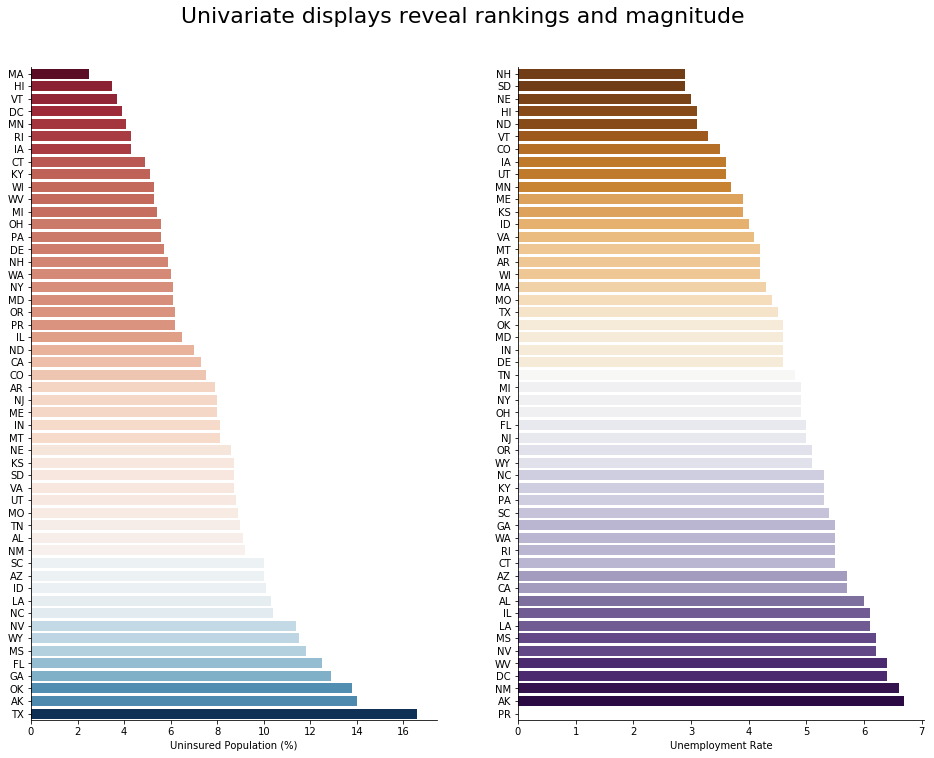

In [27]:
# Generate figure and axes
fig, ax = plt.subplots(1, 2, figsize=(16,12))

# Plot insurance data
hi_bar = hi_ur[['pct_uninsured', 'pct_uninsured_color', 'st']].sort_values(by='pct_uninsured')
sb.barplot('pct_uninsured', 'st', palette=hi_bar['pct_uninsured_color'], ax=ax[0], data=hi_bar)

# Plot unemployment data
ur_bar = hi_ur[['unemp_rate', 'unemp_rate_color', 'st']].sort_values(by='unemp_rate')
sb.barplot('unemp_rate', 'st', palette=ur_bar['unemp_rate_color'], ax=ax[1], data=ur_bar)

# Fix labels and axes
for a in ax:
    simpleaxis(a)
    a.set_ylabel('')
ax[0].set_xlabel('Uninsured Population (%)')
ax[1].set_xlabel('Unemployment Rate')
plt.suptitle('Univariate displays reveal rankings and magnitude', fontsize=22, y=0.95);

We'll get more into spatial data in a few weeks, but let's take a quick peek at maps to reveal spatial patterns if they exist. For this exercise, we are using a common set of shapes in US states.  For this reason, we don't need to use spatial data files. We can rely on the default maps in the [plotly](https://plot.ly/python/choropleth-maps/) library.

In [28]:
# Capture normalized insurance values and map them to color strings
## Create an empty list to hold the pairs
hi_map_colors = []
## For each insurance value...
for val in hi_ur['pct_uninsured']:
    ##... capture the normalized value...
    tmp_norm_val = norm['hi'].__call__(val)
    ##... capture the associated color...
    tmp_rgb = cmapper['hi'].to_rgba(val)
    ##... convert that color into a string plotly understands...
    tmp_rgb_str = 'rgb' + str(tmp_rgb[:-1])
    ##... add the pairing to the list
    hi_map_colors.append([tmp_norm_val, tmp_rgb_str])
## Sort the pairs by normalized value
hi_map_colors.sort()

# Define data schema for the insurance data
hi_map_data = [
    {
        'type': 'choropleth',
        'colorscale': hi_map_colors,
        'locations': hi_ur['st'],
        'z': hi_ur['pct_uninsured'],
        'locationmode': 'USA-states',
        'marker': {
            'line': {
                'color': '#ffffff',
                'width': 2
            }
        },
        'colorbar': {
            'title': 'Uninsured<br>Population (%)'
        }
    }
]

# Define map layout
hi_map_layout = {
    'title': 'Percentage Uninsured by State (2016)',
    'geo': {
        'scope': 'usa',
        'projection': {
            'type': 'albers usa'
        },
        'showlakes': True,
        'lakecolor': '#ffffff'
    }
}

# Define map figure
hi_map_fig = {
    'data': hi_map_data,
    'layout': hi_map_layout
}

# Plot data
pl.plotly.iplot(hi_map_fig, filename='hi_map')

In [29]:
pl.tools.CREDENTIALS_FILE

'/root/.plotly/.credentials'

In [30]:
# Capture normalized unemployment values and map them to color strings
## Create an empty list to hold the pairs
ur_map_colors = []
## For each unemployment value...
for val in hi_ur['unemp_rate']:
    ##... capture the normalized value...
    tmp_norm_val = norm['ur'].__call__(val)
    ##... capture the associated color...
    tmp_rgb = cmapper['ur'].to_rgba(val)
    ##... convert that color into a string plotly understands...
    tmp_rgb_str = 'rgb' + str(tmp_rgb[:-1])
    ##... add the pairing to the list
    ur_map_colors.append([tmp_norm_val, tmp_rgb_str])
## Sort the pairs by normalized value
ur_map_colors.sort()

# Define data schema for the unemployment data
ur_map_data = [
    {
        'type': 'choropleth',
        'colorscale': ur_map_colors[:-1], # We need to drop Puerto Rico
        'locations': hi_ur['st'],
        'z': hi_ur['unemp_rate'],
        'locationmode': 'USA-states',
        'marker': {
            'line': {
                'color': '#ffffff',
                'width': 2
            }
        },
        'colorbar': {
            'title': 'Unemployment<br>Rate (%)'
        }
    }
]

# Define map layout
ur_map_layout = {
    'title': 'Average Unemployment Rate by State (2016)',
    'geo': {
        'scope': 'usa',
        'projection': {
            'type': 'albers usa'
        },
        'showlakes': True,
        'lakecolor': '#ffffff'
    }
}

# Define map figure
ur_map_fig = {
    'data': ur_map_data,
    'layout': ur_map_layout
}

# Plot data
pl.plotly.iplot(ur_map_fig, filename='ur_map')

## Bivariate Exploration

Now that we have a sense of each series on their own, how do they relate with one another? We can explore simple correlations with a scatter plot.

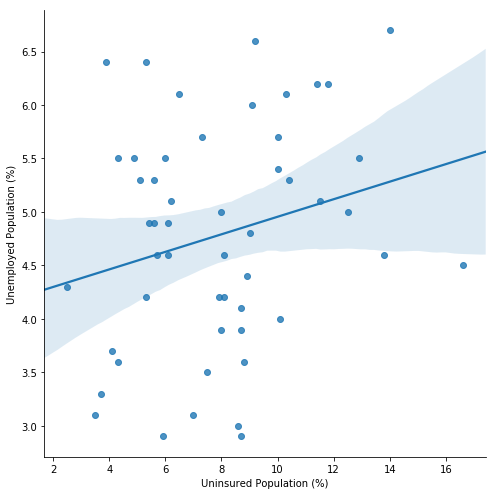

In [31]:
# Plot scatter of percent uninsured against percent unemployed
hi_ur_lm = sb.lmplot(x='pct_uninsured', y='unemp_rate', data=hi_ur, size=7)

# Fix labels
hi_ur_lm.set_xlabels('Uninsured Population (%)')
hi_ur_lm.set_ylabels('Unemployed Population (%)');